In [1]:
#####Graphical comparisons first

### Implementing AudioAnalyzer ###

"""
IMPORTS
"""

import pdb

import librosa
from librosa.feature import chroma_stft
import librosa.display

import numpy as np
import pandas as pd

from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

import seaborn as sns

"""
AUDIO ANALYZER CLASS
==========================================================================================================
"""

class AudioAnalyzer:
    
    def __init__(self, filename, fft_size=256, input_sr=41000, analyze=True):
        """
        Loads in and transform sample data from an audio file into a pandas dataframe for analysis and graphing
        
        Input: 
            filename: relative path to audio file
            fft_size: The number of frequency bins for the fft analysis. Defaults to 256
            input_sr: the sample rate of the input audio file. Defaults to 41000
        """
        y, sr = librosa.load(filename, sr=input_sr)
        self.y = y
        self.sr = sr
        self.fft_size = fft_size
        if analyze:
            self.spectrum_analysis()
        
    def change_fft_bin_size(self, size):
        """
           Optionally changes the number of fft bins after initialization.
        """
        self.fft_size = size
        self.spectrum_analysis()
        
    def spectrum_analysis(self):
        """
        Runs spectrum analysis on the input audio file. Sets and returns a dataframe with frequency information across all fft bins. 
        Amplitudes are averaged at each frequency.
        Note: This method must be called before any analysis or plotting can be done on the class instance. 
        """
        self.df = pd.DataFrame(np.abs(librosa.stft(self.y, n_fft=self.fft_size)))
        
        bins = librosa.fft_frequencies(sr=self.sr, n_fft=self.fft_size)
        
        self.df['bins'] = bins / 1000. # divide by 1000 lets us display in kHz
        
        self.df['average_amplitude'] = self.df.mean(axis=1)
        self.df = self.df[['bins', 'average_amplitude']]
        return self.df
    
    def plot_spectrum(self, min_freq=0, max_freq=None, fill=False, title="Spectrogram - Average Frequency"):
        
        """
        Plots a single spectrogram of averaged frequencies across all fft bins. Uses the generated dataframe as the source. 
        """
        
        max_freq = max_freq or 20000.
        window = self.df.loc[(self.df.bins * 1000. >= min_freq) & (self.df.bins * 1000. <= max_freq)].copy()
        window['scaled_amplitude'] = np.interp(window.average_amplitude, (0., max(window.average_amplitude)), (0., 1.))
        window.plot(x='bins', y='scaled_amplitude', figsize=(16,4))
        if fill:            
            plt.fill_between(self.df.bins, self.df.average_amplitude)
        
        legend = plt.legend()
        legend.remove()
        plt.xlabel("Frequency (kHz)", fontsize=20)
        plt.ylabel("Amplitude (scaled)", fontsize=20)
        plt.title(title, fontsize=26)



"""
SIGNAL COMPARE CLASS
==========================================================================================================
"""        
        
        
class SpectrumCompare():
    
    def __init__(self, original, modified):
        """
        Compares the frequency and amplitude information of two AudioAnalyzer class instances. 
        
        Input:
            original, modified: the two AudioAnalyzer class instances.
        """
        self.original_df = original.df
        self.modified_df = modified.df
        
        self.dfs = [self.original_df, self.modified_df]
        
        self.get_max_average(self)
        self.scale_amplitudes(self)
        self.get_ratio_df(self)
    
    def plot_spectrum_group(self,
                            spec_1=True,
                            spec_2=True,
                            title="Comparison of Frequency Amplitudes",
                            xlabel="Frequency (kHz)",
                            ylabel="Scaled Amplitude",                             
                            frange=None,
                            ratio=False,
                            legend=["Spectrum 1", "Spectrum 2", "Signal Diff.", "Threshold"],
                            threshold=False,
                           ):  
        """
        Plots a spectrogram comparing the frequencies and relative amplitudes at each fft bin of the two AudioAnalyzer class instances. 
        Plots up to four lines:
            first AudioAnalyzer class instance - frequency and amplitude
            Second AudioAnalyzer class instance - frequency and amplitude
            Difference in amplitude at each bin
            Threshold - Shows where the first or second AudioAnlyzer amplitude is greater (relative hot or old spots)
        """
        
        dfs = self.dfs.copy()
        fig = plt.figure(figsize=(16,8))
        
        if frange:
            for i, df in enumerate(dfs):
                dfs[i] = df.loc[(df.bins * 1000. >= frange[0]) & (df.bins * 1000. <= frange[1])]
        else:
            dfs = self.dfs
        
        
        if spec_1: plt.plot(dfs[0].bins, dfs[0].scaled_amplitude, label=legend[0], c="steelblue")
        if spec_2: plt.plot(dfs[1].bins, dfs[1].scaled_amplitude, label=legend[1], c="coral")

        if ratio:
            if frange:                
                ratio_df = self.ratio_df[(self.ratio_df.bins * 1000. >= frange[0]) & (self.ratio_df.bins * 1000. <= frange[1])]
                plt.plot(ratio_df['bins'], ratio_df['scaled_amplitude'], label=legend[2], c="forestgreen", linestyle="-.")
            else:
                plt.plot(self.ratio_df['bins'], self.ratio_df['scaled_amplitude'], label=legend[2], c="forestgreen")
        
        if threshold and frange:
            plt.plot([frange[0] / 1000, frange[1] / 1000], [0.5, 0.5], linestyle="--", label=legend[3], c="r")
        
        plt.title(title, fontsize=24)
        plt.xlabel(xlabel, fontsize=20)
        plt.ylabel(ylabel, fontsize=20) 
        plt.legend(fontsize=14)
        
    def plot_spectrum_heatmap(self, 
                               plot_spec1=True,
                               frange=[], 
                               title="Audio Comparison", 
                               cmap="plasma",
                               background_color="white",
                               background_alpha=0.5
                              ):
        """
        Plots a heatmap and spectrogram showing the relative hot and cool spots of thw two compared AudioAnalyzer class instances. 
        A number of options are available to customize the appearance of the generated plot. 
        """
        
#       DATAFRAME SETUP
        if plot_spec1:
            df = self.original_df
        else:
            df = self.modified_df            

        df['ratio_amplitude'] = self.ratio_df.scaled_amplitude

        df['attenuated_scaled'] = df.scaled_amplitude
        df['boosted_scaled'] = df.scaled_amplitude
        
        if len(frange):
            plot_df = df.loc[(df.bins >= frange[0] / 1000) & (df.bins <= frange[1] / 1000)]
            ratio_df = self.ratio_df.loc[(self.ratio_df.bins >= frange[0] / 1000) & (self.ratio_df.bins <= frange[1] / 1000)] 
        else:
            plot_df = df
            ratio_df = self.ratio_df

#       FIGURE SETUP
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(211, facecolor="white")
        # ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, facecolor="white", fig=fig)
        ax2 = fig.add_subplot(211, facecolor="#00000000")
        # ax2 = plt.subplot2grid((8,1), (0,0), rowspan=2, facecolor="#00000000", fig=fig)
        # fig2 = plt.figure(figsize=(32, 8))
        # cbaxes = fig2.add_subplot(32,1,1) 
        cbaxes = plt.subplot2grid((16,1), (10,0)) 
        cbaxes.set_title("Scaled Amplitude Ratio", size=14)
        
#       HEATMAP PLOT
        sns.heatmap(data=ratio_df.set_index('bins').transpose(), cbar=True, cbar_ax=cbaxes, cbar_kws={"orientation" : "horizontal"}, cmap=cmap, alpha=0.95, zorder=1, ax=ax1, vmin=0.0, vmax=1.0)
        ax1.set_xlabel("")
        ax1.set_xticks([])
        ax1.set_ylabel("")
        ax1.set_yticks([])

#       FREQUENCY PLOT        
        sns.lineplot(data=plot_df, x="bins", y="scaled_amplitude", color='black', zorder=10, ax=ax2, path_effects=[path_effects.SimpleLineShadow(), path_effects.Normal()])
        ax2.fill_between(x=plot_df.bins, y1=plot_df.scaled_amplitude, color='white', alpha=0.0)
        ax2.fill_between(x=plot_df.bins, y1=plot_df.scaled_amplitude, y2=1.0, color=background_color, alpha=background_alpha)

        ax2.set_xlabel("Frequency (kHz)", size=28)
        ax2.set_ylabel("Scaled Amplitude", size=28)     
        
        ax2.margins(0)
        fig.suptitle(title, size=36, y=0.95)
        
    
    def plot_amplitude_distributions(self, 
                                    n=10000, 
                                    size=1000,
                                    title="Amplitude Distributions",
                                    xlabel="Average Amplitude (unscaled)",
                                    ylabel="Density"
                                    ):
        amp1 = self.dfs[0].scaled_amplitude
        amp2 = self.dfs[1].scaled_amplitude

        samples_1 = []
        samples_2 = []

        for i in range(size):
            samples_1.append(np.random.choice(amp1, size=size).mean())
            samples_2.append(np.random.choice(amp2, size=size).mean())

        plt.figure(figsize=(8,6))

        sns.distplot(samples_1)
        sns.distplot(samples_2)

        plt.title(title, fontsize=18)
        plt.xlabel(xlabel, fontsize=14)
        plt.ylabel(ylabel, fontsize=14)

        t_stat, p_val = ttest_ind(samples_1, samples_2, equal_var=False)
        return pd.DataFrame([[t_stat, p_val]], columns=["T-Statistic", "P-Value"])


    @staticmethod
    def get_max_average(self):
        max_average = 0
        for df in self.dfs:
            cur_max = df.average_amplitude.max()
            max_average = cur_max if cur_max > max_average else max_average
        
        self.max_average = max_average
    
    @staticmethod
    def scale_amplitudes(self):        
        scaled_dfs = []
        for df in self.dfs:
            averaged = df['average_amplitude']
            df['scaled_amplitude'] = np.interp(averaged, (0., self.max_average), (0., 1.)) 
            scaled_dfs.append(df)            
        self.original_df, self.modified_df = scaled_dfs
        
    @staticmethod
    def get_ratio_df(self):
        
        orig_scaled = self.original_df.scaled_amplitude
        mod_scaled = self.modified_df.scaled_amplitude
        
        self.ratio_df = pd.DataFrame((mod_scaled - orig_scaled) + 0.5)
        self.ratio_df['bins'] = self.original_df.bins
        
        self.ratio_df.loc[self.ratio_df.scaled_amplitude > 1.0, ['scaled_amplitude']] = 1.0
        self.ratio_df.loc[self.ratio_df.scaled_amplitude < 0.0, ['scaled_amplitude']] = 0.0


In [2]:
#To instantiate an AudioAnalyzer instance, the first argument must point to a valid audio file.

original = AudioAnalyzer("Para4_s1.wav", input_sr=44100, fft_size=44100)
remaster_09 = AudioAnalyzer("Paragraph 4.wav", input_sr=44100, fft_size=44100)
#remaster_15 = AudioAnalyzer("audio/yesterday-2015.wav", input_sr=44100, fft_size=44100)

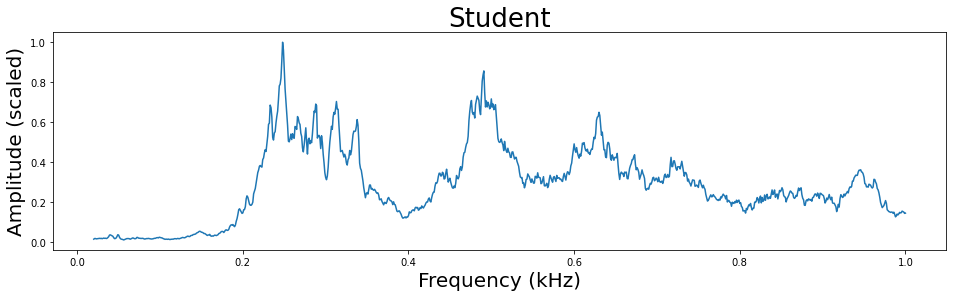

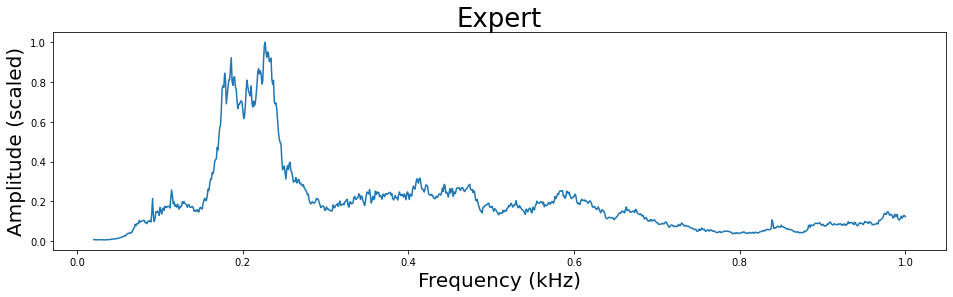

In [4]:
#Individual Spectrum plotting

original.plot_spectrum(min_freq=20, max_freq=1000, title="Student")
remaster_09.plot_spectrum(min_freq=20, max_freq=1000, title="Expert")

In [7]:
#SpectrumCompare Initialization

orig_to_09 = SpectrumCompare(original, remaster_09)


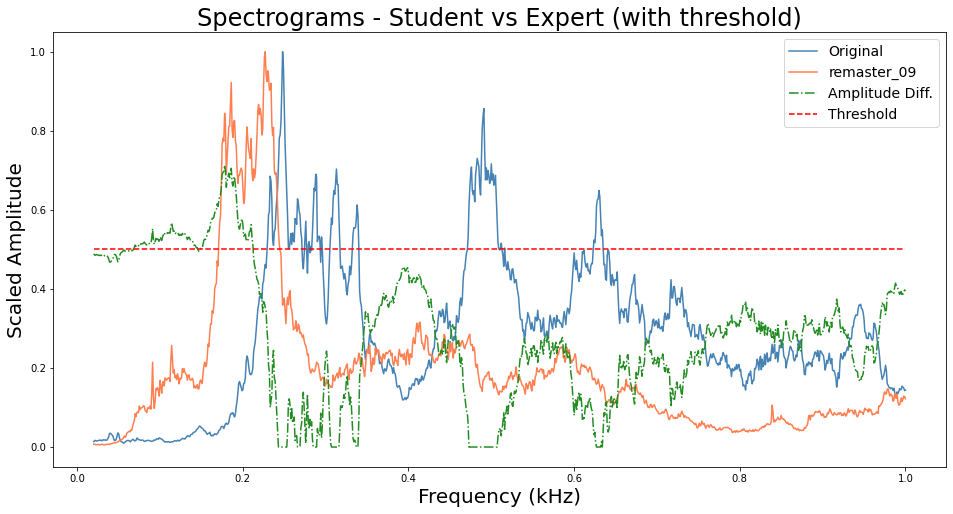

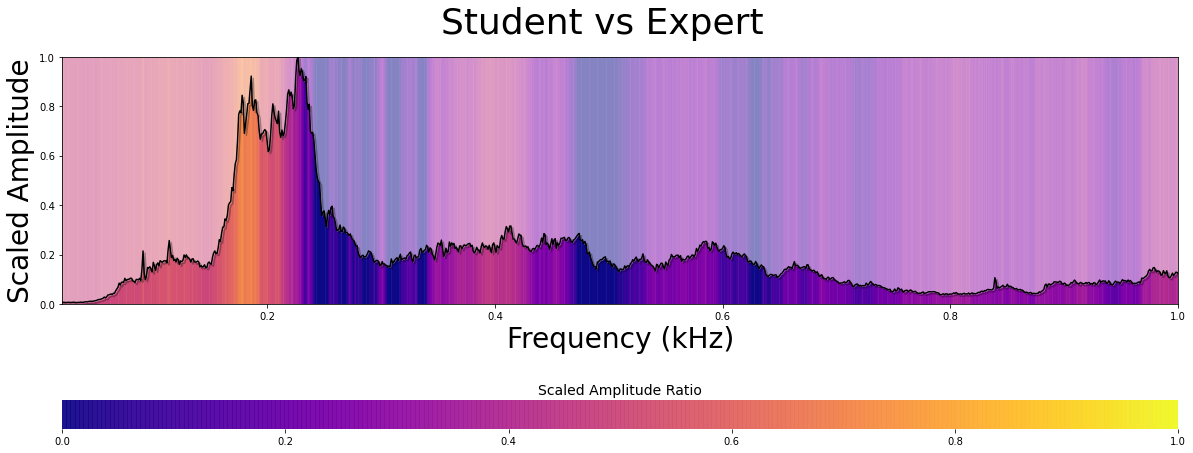

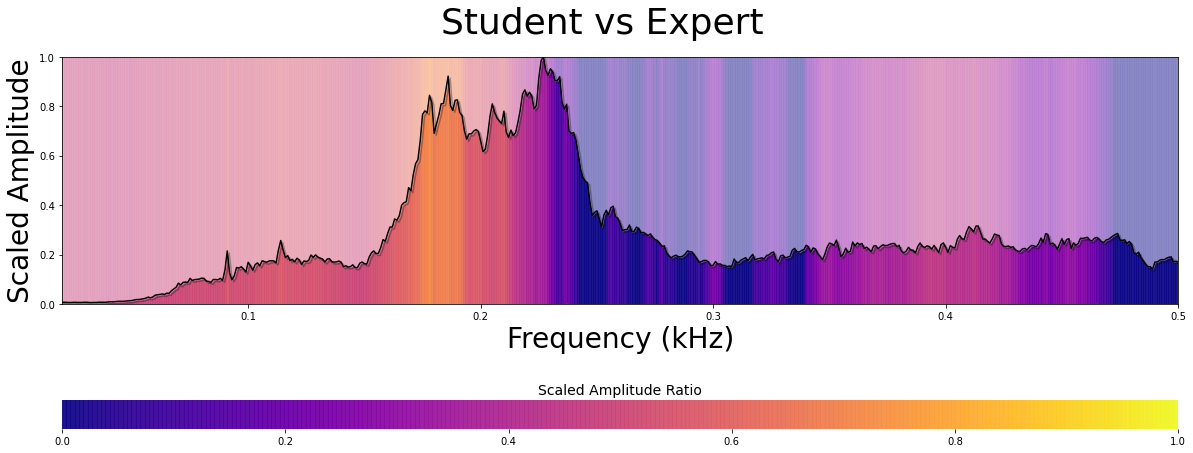

In [14]:
#Graph Types and Options for SpectrumCompare Instances


# plot_spectrum_group
#To comparing the relative amplitudes at varying frequency bins for the two excerpts.
#y-axis has been scaled from 0 to 1 so the amplitudes can be compared on the same scale.

orig_to_09.plot_spectrum_group(frange=(20,1000), 
    ratio=True, 
    threshold=True,
    title="Spectrograms - Student vs Expert (with threshold)", 
    legend=("Original", "remaster_09", "Amplitude Diff.", "Threshold")
    )

#plot_spectrum_heatmap
#This heatmap is a generalized version of the plot_spectrum_group. 
#Converts the amplitude difference to a heatmap, and displays one of the spectrograms as an overlay on that heatmap.
#"Hotter" spots indicate a larger difference in favor of the second AudioAnalyzer input. 
#"Colder" spots indicate a larger difference in favor of the first AudioAnalyzer input.

orig_to_09.plot_spectrum_heatmap(
    frange=(20,1000), 
    plot_spec1=False,
    title="Student vs Expert"
)

#plot_amplitude_distributions
#Show the mean sampling distributions of amplitudes for both AudioAnalyzer instances.
#no frequency information in these graphs. Rather, show if one excerpt is generally louder than the other.

orig_to_09.plot_spectrum_heatmap(
    frange=(20,500), 
    plot_spec1=False, 
    title="Student vs Expert"
)


C:\Users\Imalka\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Imalka\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,T-Statistic,P-Value
0,204.586035,0.0


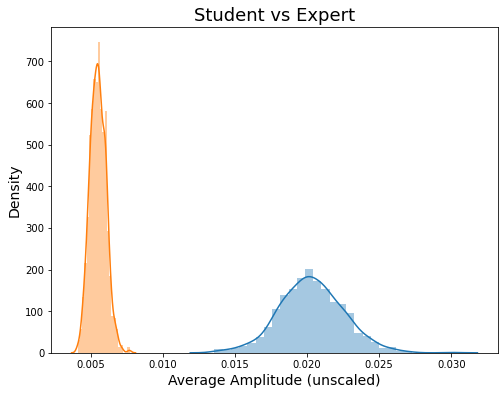

In [10]:
orig_to_09.plot_amplitude_distributions(title="Student vs Expert")

C:\Users\Imalka\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Imalka\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


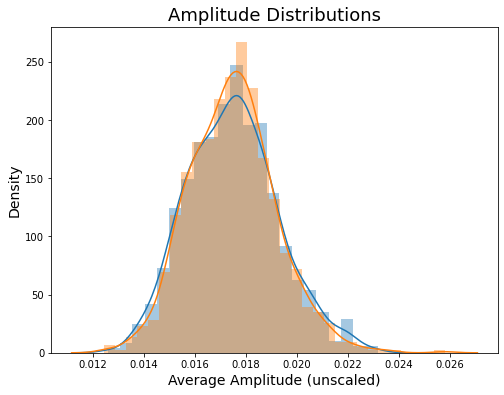

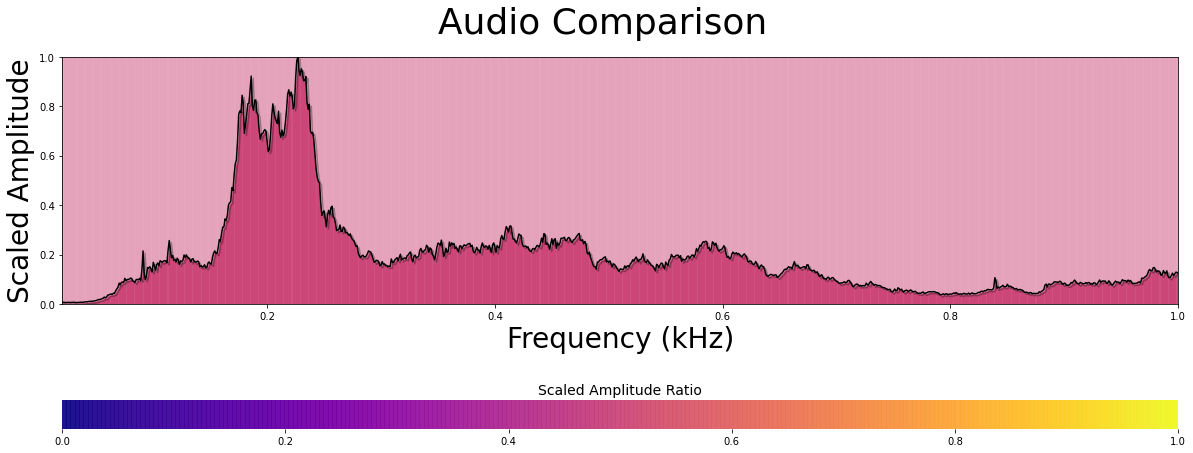

In [11]:
#compare an excerpt to itself. 
#Amplitudes are not statistically different, and the heatmap plot has no color variation.

equal = SpectrumCompare(remaster_09, remaster_09)

equal.plot_amplitude_distributions()
equal.plot_spectrum_heatmap(frange=(20,1000))